In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans # Switched to K-Means Clustering
from prophet import Prophet
from datetime import timedelta
import warnings
import warnings

# Suppress minor warnings for cleaner output
warnings.filterwarnings("ignore")

In [3]:
df_sales = pd.read_csv('sales.csv')
df_products = pd.read_csv('products.csv')
df_customers = pd.read_csv('customers.csv')
df_inventory = pd.read_csv('inventory.csv')
print("DataFrames loaded successfully: df_sales, df_products, df_customers, df_inventory")

DataFrames loaded successfully: df_sales, df_products, df_customers, df_inventory


In [4]:
# --- 2. Data Cleaning and Transformation ---

# 2.1 Convert Date Columns to Datetime Objects
df_sales['Date'] = pd.to_datetime(df_sales['Date'])
df_products['LaunchDate'] = pd.to_datetime(df_products['LaunchDate'])

# 2.2 Calculate Revenue (SalePrice_INR * QuantitySold * (1 - DiscountApplied))
df_sales['Revenue'] = (
    df_sales['SalePrice_INR'] *
    df_sales['QuantitySold'] *
    (1 - df_sales['DiscountApplied'])
)

In [5]:
# 2.3 Merge DataFrames for comprehensive analysis
df_merged = df_sales.merge(df_products, on='ProductID', how='left')
df_merged = df_merged.merge(df_customers, on='CustomerID', how='left')

# 2.4 Check for missing values and duplicates
print("\nMissing values check (top 5 columns):")
print(df_merged.isnull().sum().head())
# Assuming few missing values, we'll drop them for simplicity in this analysis
df_merged.dropna(inplace=True)


Missing values check (top 5 columns):
SaleID           0
ProductID        0
Date             0
QuantitySold     0
SalePrice_INR    0
dtype: int64


In [6]:
# 2.3 Merge DataFrames for comprehensive analysis
df_merged = df_sales.merge(df_products, on='ProductID', how='left')
df_merged = df_merged.merge(df_customers, on='CustomerID', how='left')

# 2.4 Check for missing values and duplicates
print("\nMissing values check (top 5 columns):")
print(df_merged.isnull().sum().head())
# Assuming few missing values, we'll drop them for simplicity in this analysis
df_merged.dropna(inplace=True)


Missing values check (top 5 columns):
SaleID           0
ProductID        0
Date             0
QuantitySold     0
SalePrice_INR    0
dtype: int64


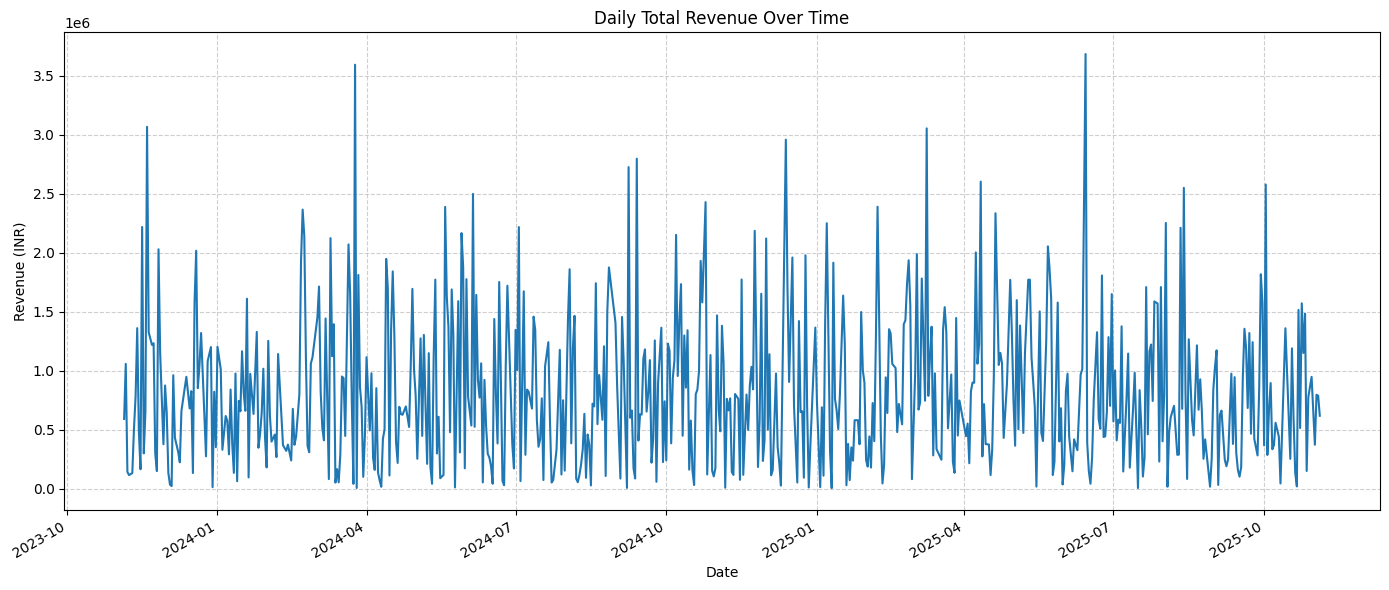

Generated plot: Daily Total Revenue Over Time


In [7]:
 #3.1 Daily Revenue Time Series
daily_revenue = df_sales.groupby('Date')['Revenue'].sum()

plt.figure(figsize=(14, 6))
daily_revenue.plot(title='Daily Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue (INR)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print("Generated plot: Daily Total Revenue Over Time")

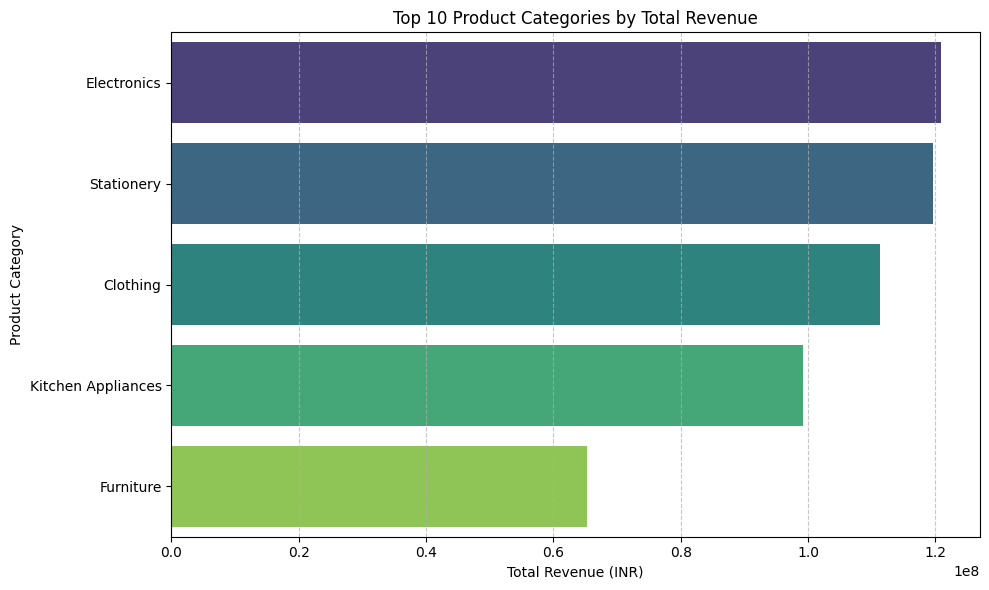

Generated plot: Top 10 Product Categories by Total Revenue


In [8]:
# 3.2 Top 10 Product Categories by Revenue
category_revenue = df_merged.groupby('Category')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=category_revenue.index, x=category_revenue.values, palette='viridis')
plt.title('Top 10 Product Categories by Total Revenue')
plt.xlabel('Total Revenue (INR)')
plt.ylabel('Product Category')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Generated plot: Top 10 Product Categories by Total Revenue")

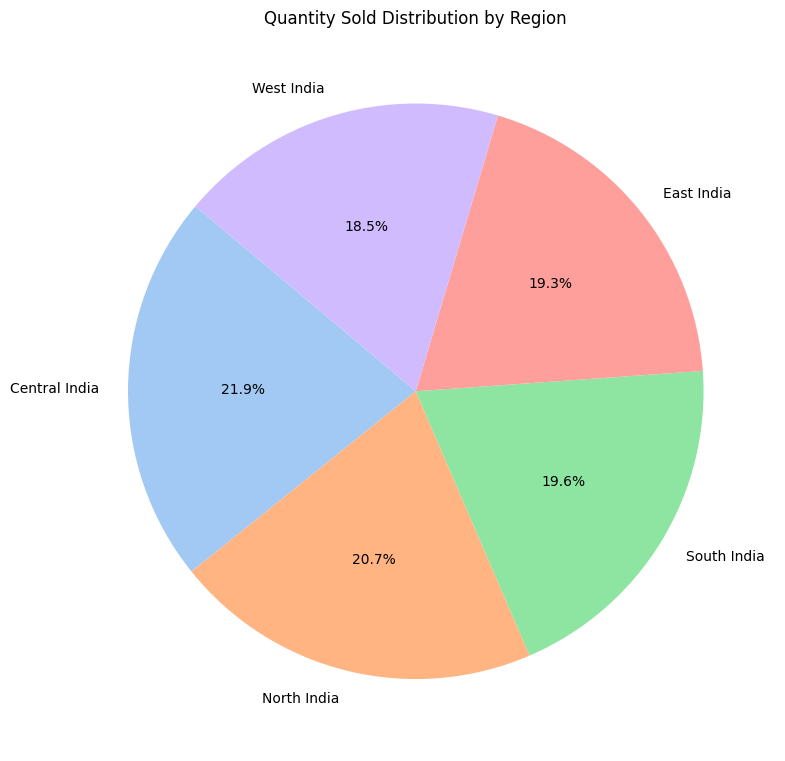

Generated plot: Quantity Sold Distribution by Region


In [9]:
# 3.3 Sales Distribution by Region
region_sales = df_merged.groupby('Region')['QuantitySold'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 8))
plt.pie(region_sales, labels=region_sales.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Quantity Sold Distribution by Region')
plt.ylabel('') # Remove y-label for clean pie chart
plt.tight_layout()
plt.show()
print("Generated plot: Quantity Sold Distribution by Region")

In [10]:
# --- 4. Demand Forecasting (Prophet Model) ---


# 4.1 Prepare Time Series Data for Prophet (requires 'ds' and 'y' columns)
prophet_df = df_sales.groupby('Date')['QuantitySold'].sum().reset_index()
prophet_df.columns = ['ds', 'y']

Prophet model fitted successfully.


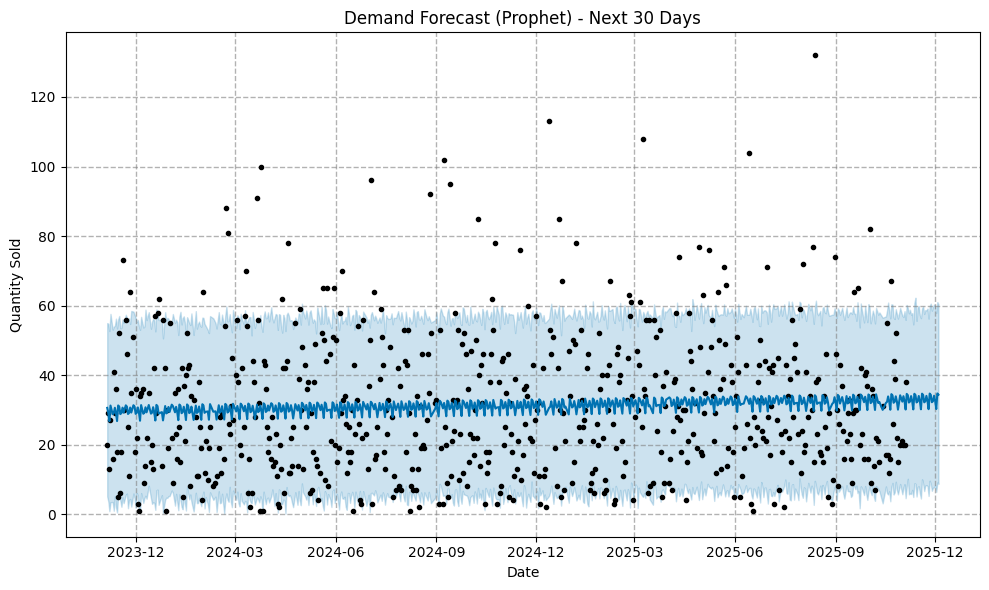

Generated plot: Demand Forecast (Prophet)
Exported demand forecast to demand_forecast_prophet.csv


In [11]:
model = Prophet(
        yearly_seasonality=False, # Assuming data is short or seasonality is mainly weekly
        weekly_seasonality=True,
        daily_seasonality=False
    )
model.fit(prophet_df)
print("Prophet model fitted successfully.")

    # 4.3 Generate Forecasts (30 steps ahead)
future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)

    # Extract the last 30 days of the forecast
df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
df_forecast.columns = ['Date', 'Forecast_Quantity', 'Lower_CI', 'Upper_CI']
df_forecast['Date'] = pd.to_datetime(df_forecast['Date']).dt.date # Convert to date object for clean display

    # Plot the forecast
fig = model.plot(forecast, xlabel='Date', ylabel='Quantity Sold')
plt.title('Demand Forecast (Prophet) - Next 30 Days')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print("Generated plot: Demand Forecast (Prophet)")

    # 4.4 Export Forecast Results
forecast_output_file = 'demand_forecast_prophet.csv'
df_forecast.to_csv(forecast_output_file, index=False)
print(f"Exported demand forecast to {forecast_output_file}")

In [14]:
!pip install --upgrade prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 91.2 MB/s eta 0:00:00
  Attempting uninstall: prophet
    Found existing installation: prophet 1.1.7
    Uninstalling prophet-1.1.7:
      Successfully uninstalled prophet-1.1.7


In [12]:
# --- 5. Customer Segmentation (RFM + K-Means Clustering) ---

# 5.1 RFM Calculation (Same as before)
snapshot_date = df_sales['Date'].max() + timedelta(days=1)

df_rfm = df_sales.groupby('CustomerID').agg(
    Recency=('Date', lambda x: (snapshot_date - x.max()).days), # Days since last purchase
    Frequency=('SaleID', 'count'), # Total number of transactions
    Monetary=('Revenue', 'sum') # Total revenue generated
).reset_index()

# 5.2 Handling Skewness and Standardization (Same as before)
df_rfm_log = df_rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log1p)
scaler = StandardScaler()
df_rfm_scaled = scaler.fit_transform(df_rfm_log)
df_rfm_scaled = pd.DataFrame(df_rfm_scaled, columns=['R_Scaled', 'F_Scaled', 'M_Scaled'])


# 5.3 K-Means Clustering (Determine optimal K, here we assume K=4 for illustration)
# Elbow method is typically used to find K, but for brevity, we'll set K=4
k = 4
print(f"Applying K-Means clustering with K={k}...")
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_rfm['Cluster'] = kmeans.fit_predict(df_rfm_scaled)


# 5.4 Cluster Profiling
df_rfm = df_rfm.merge(df_customers[['CustomerID', 'Location', 'Gender']], on='CustomerID', how='left')
cluster_profiles = df_rfm.groupby('Cluster').agg(
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean'),
    Total_Customers=('CustomerID', 'count')
).sort_values(by='Avg_Monetary', ascending=False)
print(f"\nK-Means Cluster Profiles (K={k}):")
print(cluster_profiles.to_string())


Applying K-Means clustering with K=4...

K-Means Cluster Profiles (K=4):
         Avg_Recency  Avg_Frequency  Avg_Monetary  Total_Customers
Cluster                                                           
0         114.281250       6.937500  2.617082e+06               96
3          22.098592       5.746479  1.715964e+06               71
1         208.044944       3.943820  1.415066e+06               89
2         259.571429       1.785714  4.119815e+05               42


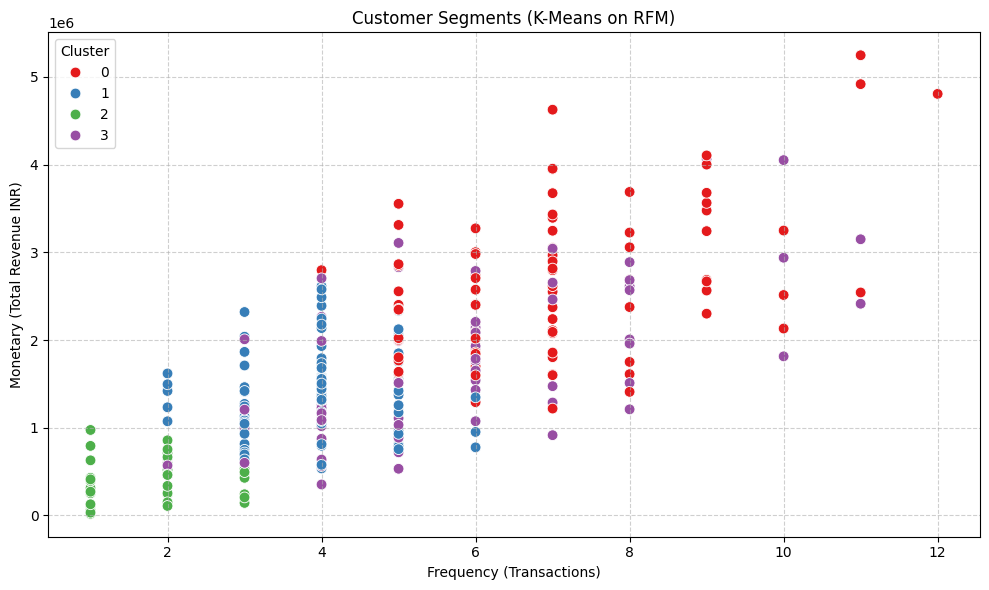

Generated plot: Customer Segments (K-Means on RFM)


In [13]:
# 5.5 Visualize Clusters (Scatter plot of F vs M)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=df_rfm, palette='Set1', s=60)
plt.title('Customer Segments (K-Means on RFM)')
plt.xlabel('Frequency (Transactions)')
plt.ylabel('Monetary (Total Revenue INR)')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print("Generated plot: Customer Segments (K-Means on RFM)")

In [14]:
#5.6 Define and Map Segments (Based on typical RFM logic)
# Note: Assignment is based on visual inspection of the cluster means.
segment_map = {
    cluster_profiles.index[0]: 'Champions',  # Highest M, F
    cluster_profiles.index[1]: 'Loyal Customers', # High M, F
    cluster_profiles.index[2]: 'At Risk', # Low M, F, High R
    cluster_profiles.index[3]: 'New/Lapsed Customers' # Lowest M, F, or high R
}

df_rfm['Segment'] = df_rfm['Cluster'].map(segment_map)
df_segments_export = df_rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Segment', 'Location', 'Gender']]

# 5.7 Export Segmentation Results
segment_output_file = 'customer_segments_kmeans_rfm.csv' # Updated file name
df_segments_export.to_csv(segment_output_file, index=False)
print(f"\nExported customer segments to {segment_output_file}")



Exported customer segments to customer_segments_kmeans_rfm.csv
